# Multi-layer Perceptron
mRNA data.       
Middle exclusion applied to the entire dataset (train and test).   
Or no middle exclusion (train or test).

The "ForRNAlight" data files were generated by RNAlight_133.
Similar code was used to test RNAlight and LightGBM in RNAlight_137.
Similar code was used to test Random Forest in RF_201.

In [1]:
import time
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())

2024-06-05 19:42:37.667606
Python 3.10.12


In [2]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings
import sklearn
import joblib
print('sklearn',sklearn.__version__)
print('Done')

sklearn 1.2.2
Done


In [3]:
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')
print(SEED)

100


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
print('Done')

Done


In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
print('Done')

Done


In [6]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/RNAlight/'  # must end in "/"
    output_dir=PATH+'My Drive/data/Localization/RNAlight/'
except:
    IN_COLAB = False
    DATA_DIR = './'    # Mac
    MODEL_DIR = './'    # Mac
    output_dir = './'
print('DATA DIR', DATA_DIR)

Running on CoLab
Mounted at /content/drive/
DATA DIR /content/drive/My Drive/data/Localization/RNAlight/


In [8]:
def build_model():
    SHAPE = 1344   # empirically from array of k-mer profiles
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype='float32',input_dim=SHAPE)  # input_dim to be determined
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [9]:
test = build_model()
print(test)
test = None

In [10]:
class stats_collector:
    def __init__(self):
        self.reset_statistics()
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_mcc=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
    def _append_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
    def compute_performance(self,y_test,yhat_pred,yhat_classes,verbose=False):
        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        self._append_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
        if verbose:
            self._show_confusion(y_test,yhat_pred,yhat_classes)
            self._show_statistics(accuracy,precision,recall,f1,mcc,auprc,auroc)
    def _show_confusion(self,y_test,yhat_pred,yhat_classes):
            print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            cm1 = confusion_matrix(y_test,yhat_classes)
            print('Confusion matrix\n',cm1)
            cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
            print('Normalized matrix\n',cm2)
    def _show_statistics(self,accuracy,precision,recall,f1,mcc,auprc,auroc):
            print('accuracy:',accuracy,'precision:',precision,'recall:',recall,\
                  'F1:',f1,'MCC:',mcc,'AUPRC:',auprc,'AUROC:',auroc)
    def _show_variance(self, name, stats_list):
        if name=='MCC':
            print('%10s %5.3f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        else:
            print('%10s %5.2f mean, %6.3f stdev' % (name,np.mean(stats_list),np.std(stats_list) ) )
        print(stats_list)
    def dump_all(self):
        self._show_variance('accuracy', self.cv_accuracy)
        self._show_variance('precision',self.cv_precision)
        self._show_variance('recall',   self.cv_recall)
        self._show_variance('F1',       self.cv_f1)
        self._show_variance('MCC',      self.cv_mcc)
        self._show_variance('AUPRC',    self.cv_auprc)
        self._show_variance('AUROC',    self.cv_auroc)

In [11]:
# From RNAlight notebook
def _count_kmer(Dataset,k): # k = 3,4,5

    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']

    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))

    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))

    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))

    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1  # ,df1_rawcount

In [12]:
# From RNAlight notebook
def load_dataframe(cyto_f,nuc_f):
    print('load dataframe')
    dataset_cyto = pd.read_csv(cyto_f,sep='\t',index_col = False)    #1806
    dataset_nuc = pd.read_csv(nuc_f,sep='\t',index_col = False)    #1986
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    return dataset_cyto,dataset_nuc

In [13]:
# Added
def rebalance(dataset_cyto,dataset_nuc):
    print('sample down to balance classes')
    min_size = min(len(dataset_cyto),len(dataset_nuc))
    # random sampling without replacement
    dataset_cyto = dataset_cyto.sample(min_size, random_state=SEED)
    dataset_nuc  = dataset_nuc.sample(min_size,  random_state=SEED)
    print( len(dataset_cyto), 'cytoplasmic samples')
    print( len(dataset_nuc),  'nuclear samples')
    return dataset_cyto,dataset_nuc

In [14]:
# From RNAlight notebook
def extract_features_and_split(dataset_cyto,dataset_nuc):
    print('add labels, concatenate')
    # Set the tag of RCI(log2FC): nuclear 1 / cytosol 0
    dataset_nuc['tag'] = 1;dataset_cyto['tag'] = 0
    # merge the nuc and cyto dataset
    dataset = pd.concat([dataset_nuc,dataset_cyto]) # 3792

    print('dedupe (probably not necessary)')
    # remove duplications(actually,each RNA is unique in its class)
    dataset.drop_duplicates(keep="first",subset=["ensembl_transcript_id","name","cdna"],inplace=True) # 3792

    print('count kmers')
    # k = 3,4,5 count the normalized and raw count of kmer
    df_kmer_345 = _count_kmer(dataset,345)   # df_kmer_345,df_kmer_345_rawcount =

    # We commented this out. No need to save the tsv.
    # df_kmer_345.to_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t')
    # This was commented out in the original. Seems they reran using saved kmers. Should test if file exists.
    # load kmer file
    # df_kmer_345 = pd.read_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)

    # convert to x:kmer-freq , y:label
    del df_kmer_345['ensembl_transcript_id']
    x_kmer = df_kmer_345.values
    y_kmer = y_kmer = np.array(df_kmer_345.index)

    # split into training and test sets (9:1)
    print('train/test split')
    x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = 0.1, random_state = SEED)

    #print('Apply cross-validation to all the data (no test set withheld)')
    #x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = None, random_state = SEED)
    print('train set shape',x_train.shape)
    # Added
    labels,counts = np.unique(y_train,return_counts=True)
    print('train set labels', labels, 'counts',counts)
    labels,counts = np.unique(y_test,return_counts=True)
    print('test set labels', labels, 'counts',counts)
    return x_train, x_test, y_train, y_test

In [15]:
def do_cv(x_train, y_train):
    stats = stats_collector()
    for round in range(1,3):   # RESTORE TO RANGE(1,3)
        fold=0
        splitter = KFold(n_splits=5)  # RESTORE TO SPLITS=5
        for train_index, valid_index in splitter.split(x_train):
            fold += 1
            print('Round', round, 'Fold', fold)
            print('Num samples in train and valid sets:', len(train_index), len(valid_index))
            print('Train')
            lgb = build_model()
            history = lgb.fit(x_train[train_index], y_train[train_index],
                             epochs=150, verbose=0)  # RESTORE TO EPOCHS 300?
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Validate')
            x_valid = x_train[valid_index]
            y_valid = y_train[valid_index]

            yhat_pred=lgb.predict(x_valid, verbose=0)
            yhat_classes=np.where(yhat_pred > 0.5, 1, 0)
            #yhat_classes= lgb.predict(x_valid)  # get 0 or 1
            #yhat_pairs=   lgb.predict_proba(x_valid)  # get [ prob of 0, prob of 1 ]
            #yhat_pred=    [pair[1] for pair in yhat_pairs]
            stats.compute_performance(y_valid,yhat_pred,yhat_classes,verbose=False)
    return stats

In [16]:
if False:
    print('Use the RNAlight training set (already has middle excluded)')
    cyto_f = DATA_DIR+'02_mRNA_info_cyto_transcript.tsv'
    nuc_f  = DATA_DIR+'02_mRNA_info_nuc_transcript.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    dataset_cyto,dataset_nuc = load_dataframe(cyto_f,nuc_f)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

In [17]:
if False:
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

In [18]:
if False:
    print('Use our lncATLAS training set "middle exclusion" (CN-RCI < -2 or CN-RCI > 0)')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-2.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    dataset_cyto,dataset_nuc = load_dataframe(cyto_f,nuc_f)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

Use our lncATLAS training set "middle exclusion" (CN-RCI < -2 or CN-RCI > 0)
Data files:
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIgt0.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIlt-2.canonical.tsv
load dataframe
7909 cytoplasmic samples
987 nuclear samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
987 cytoplasmic samples
987 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (1776, 1344)
train set labels [0 1] counts [881 895]
test set labels [0 1] counts [106  92]
Round 1 Fold 1
Num samples in train and valid sets: 1420 356
Train


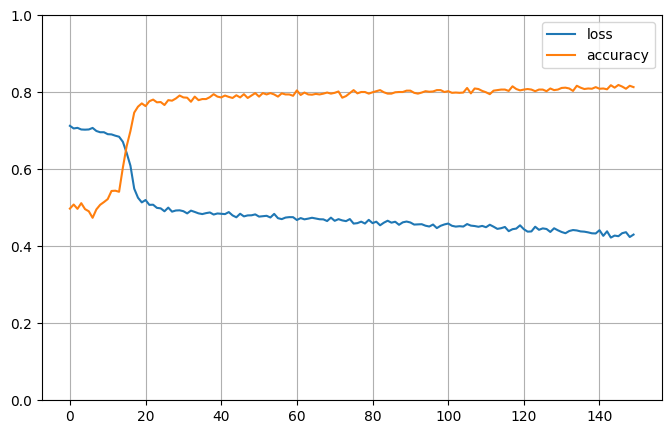

Validate
Round 1 Fold 2
Num samples in train and valid sets: 1421 355
Train


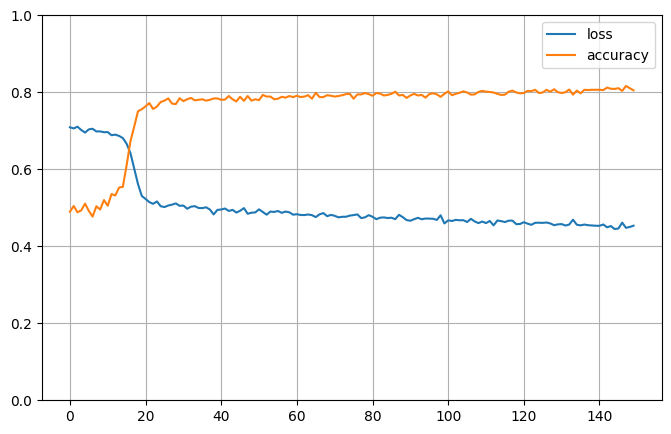

Validate
Round 1 Fold 3
Num samples in train and valid sets: 1421 355
Train


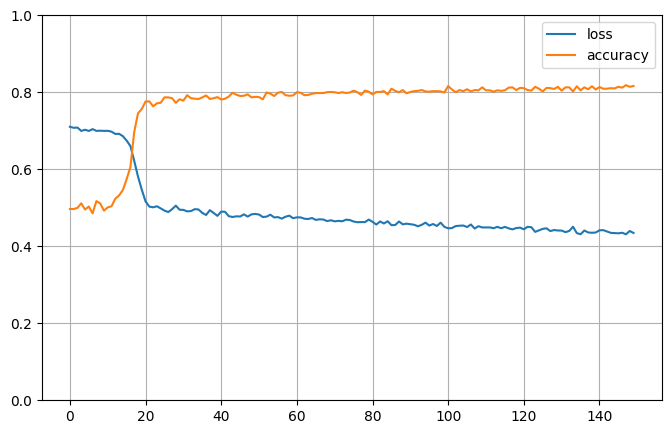

Validate
Round 1 Fold 4
Num samples in train and valid sets: 1421 355
Train


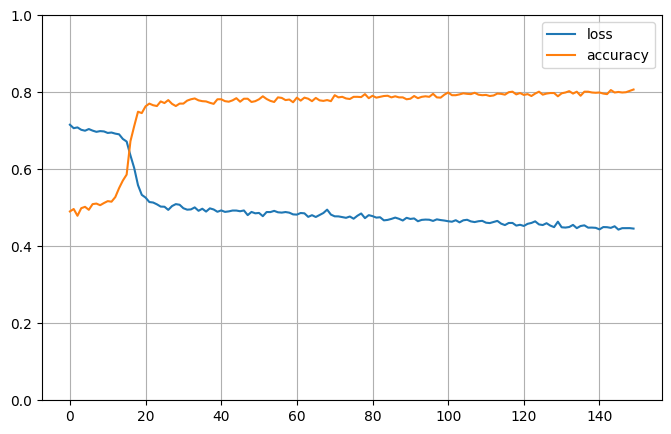

Validate
Round 1 Fold 5
Num samples in train and valid sets: 1421 355
Train


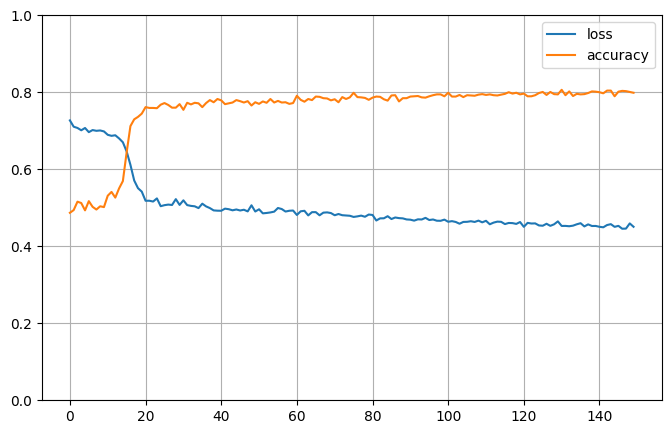

Validate
Round 2 Fold 1
Num samples in train and valid sets: 1420 356
Train


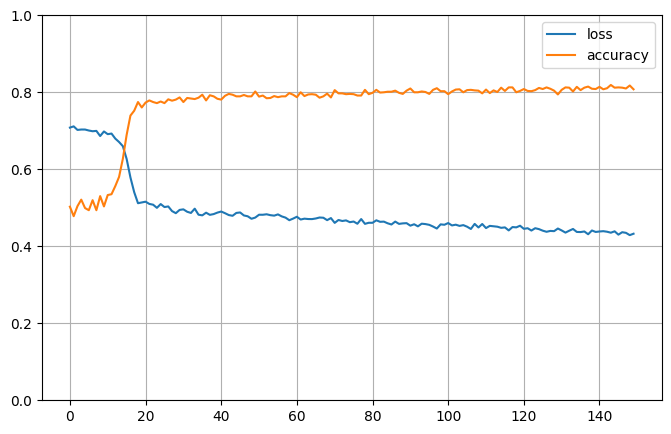

Validate
Round 2 Fold 2
Num samples in train and valid sets: 1421 355
Train


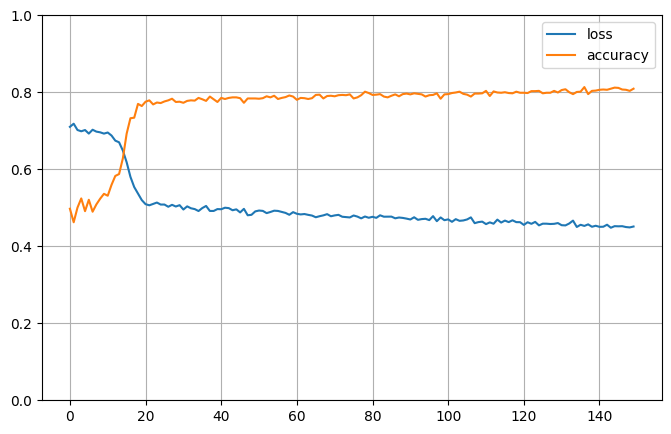

Validate
Round 2 Fold 3
Num samples in train and valid sets: 1421 355
Train


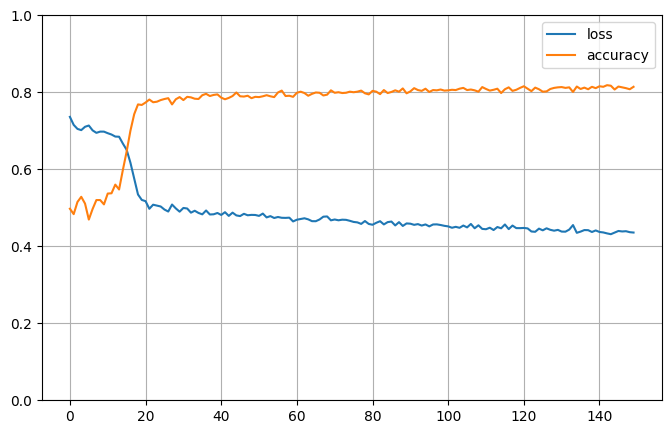

Validate
Round 2 Fold 4
Num samples in train and valid sets: 1421 355
Train


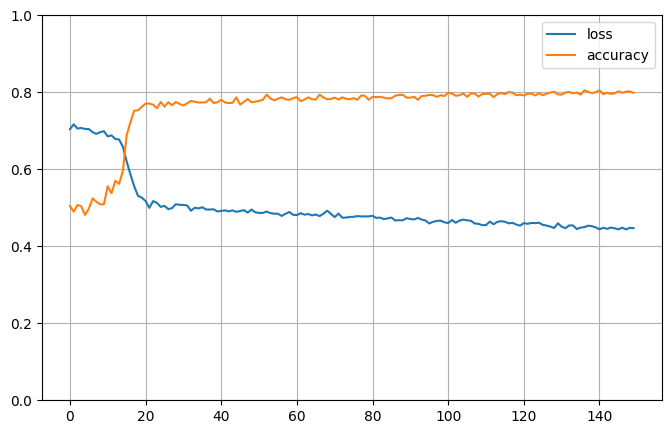

Validate
Round 2 Fold 5
Num samples in train and valid sets: 1421 355
Train


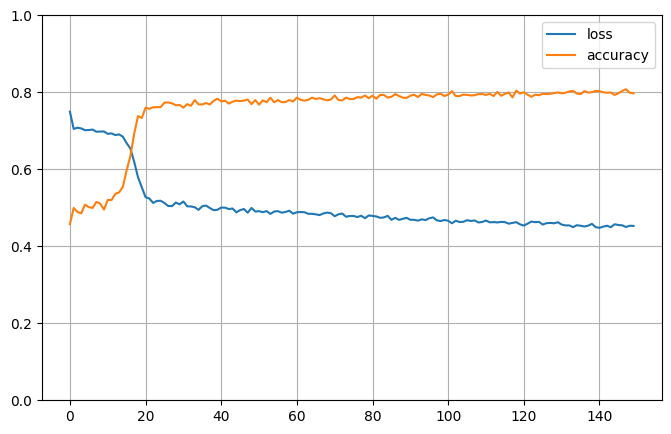

Validate

Cross validation results
  accuracy 80.49 mean,  2.404 stdev
[78.08988764044943, 80.84507042253522, 77.46478873239437, 83.38028169014085, 83.09859154929578, 77.80898876404494, 81.12676056338029, 77.46478873239437, 82.8169014084507, 82.8169014084507]
 precision 81.99 mean,  3.411 stdev
[80.44692737430168, 80.66298342541437, 76.96629213483146, 84.71337579617835, 86.98224852071006, 80.0, 81.11111111111111, 77.58620689655173, 84.51612903225806, 86.90476190476191]
    recall 78.72 mean,  1.680 stdev
[77.00534759358288, 81.56424581005587, 77.8409090909091, 79.16666666666666, 79.45945945945945, 77.00534759358288, 81.56424581005587, 76.70454545454545, 77.97619047619048, 78.91891891891892]
        F1 80.29 mean,  2.062 stdev
[78.68852459016395, 81.11111111111111, 77.40112994350281, 81.84615384615384, 83.05084745762711, 78.4741144414169, 81.33704735376045, 77.14285714285715, 81.11455108359135, 82.71954674220964]
       MCC 0.610 mean,  0.049 stdev
[0.5622417032086137, 0.616876734016957

In [19]:
if True:   # just to be sure
    print('Use our lncATLAS training set "middle exclusion" (CN-RCI < -2 or CN-RCI > 0)')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt0.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-2.canonical.tsv'
    print('Data files:')
    print(cyto_f,'\n',nuc_f)
    dataset_cyto,dataset_nuc = load_dataframe(cyto_f,nuc_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

In [20]:
if False:
    print('Use our lncATLAS training set "all" (-inf <= CN-RCI <= +inf)')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt-1.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-1.canonical.tsv'
    print(cyto_f,'\n',nuc_f)
    dataset_cyto,dataset_nuc = load_dataframe(cyto_f,nuc_f)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

Use our lncATLAS training set "all" (-inf <= CN-RCI <= +inf)
/content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIgt-1.canonical.tsv 
 /content/drive/My Drive/data/Localization/RNAlight/ForRNAlight.mRNA_RCIlt-1.canonical.tsv
load dataframe
12763 cytoplasmic samples
3330 nuclear samples
Rebalance (sample down the majority class) and repeat
sample down to balance classes
3330 cytoplasmic samples
3330 nuclear samples
add labels, concatenate
dedupe (probably not necessary)
count kmers
train/test split
train set shape (5994, 1344)
train set labels [0 1] counts [2995 2999]
test set labels [0 1] counts [335 331]
Round 1 Fold 1
Num samples in train and valid sets: 4795 1199
Train


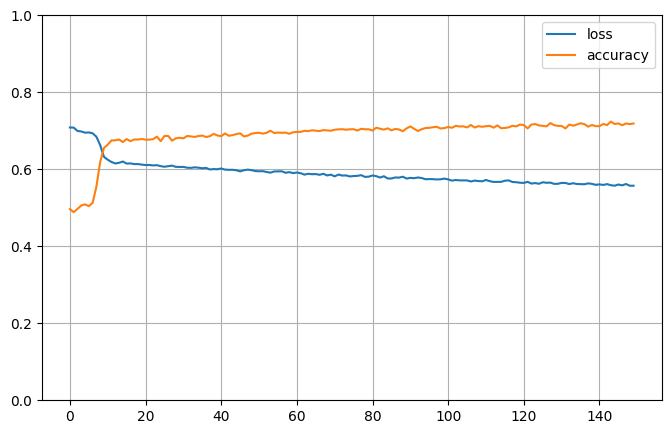

Validate
Round 1 Fold 2
Num samples in train and valid sets: 4795 1199
Train


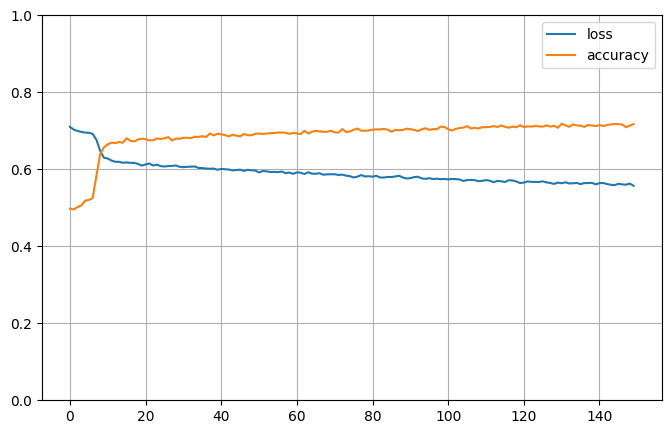

Validate
Round 1 Fold 3
Num samples in train and valid sets: 4795 1199
Train


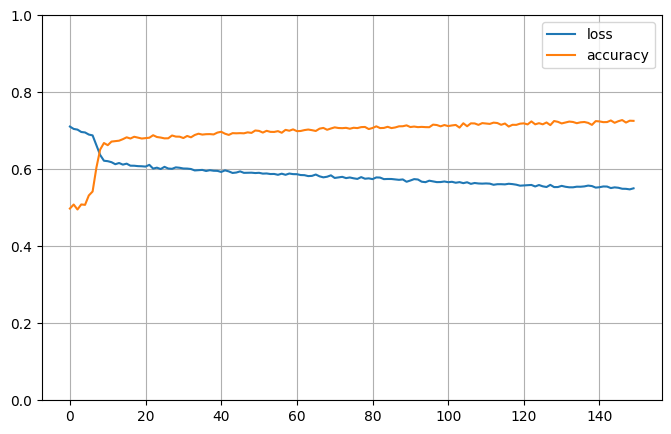

Validate
Round 1 Fold 4
Num samples in train and valid sets: 4795 1199
Train


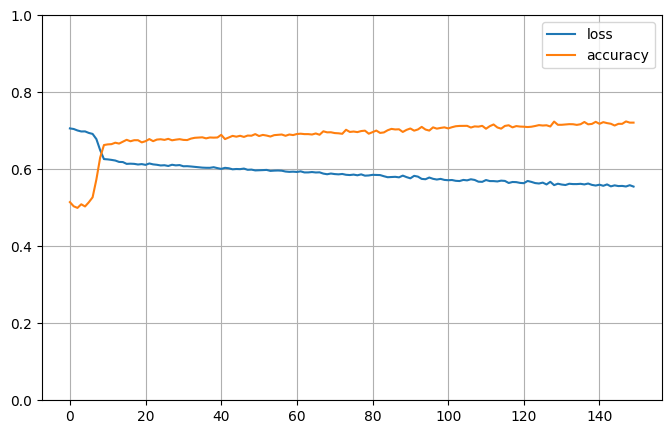

Validate
Round 1 Fold 5
Num samples in train and valid sets: 4796 1198
Train


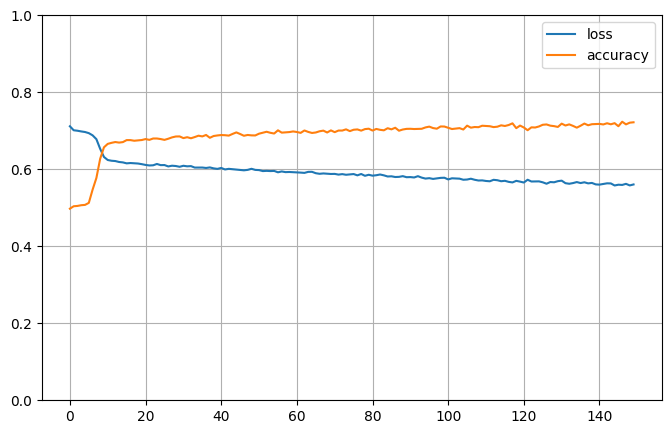

Validate
Round 2 Fold 1
Num samples in train and valid sets: 4795 1199
Train


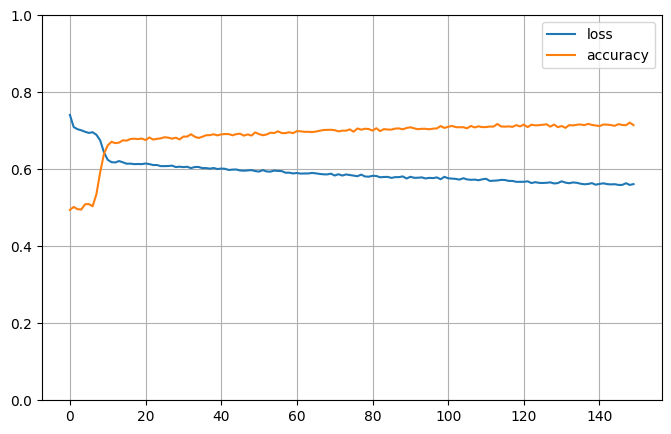

Validate
Round 2 Fold 2
Num samples in train and valid sets: 4795 1199
Train


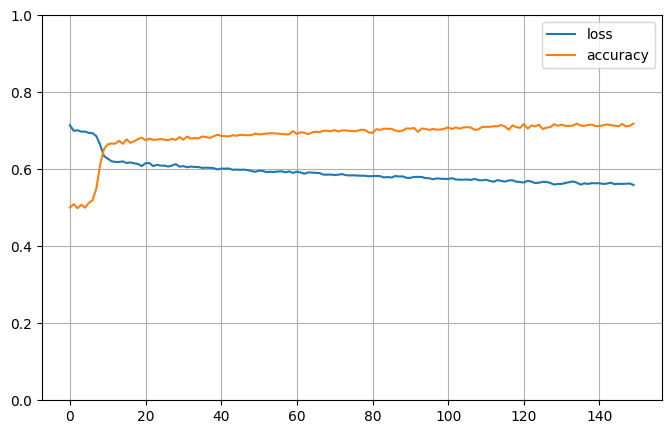

Validate
Round 2 Fold 3
Num samples in train and valid sets: 4795 1199
Train


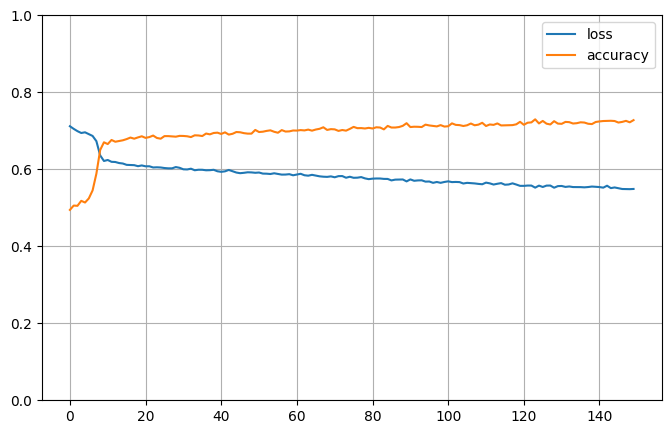

Validate
Round 2 Fold 4
Num samples in train and valid sets: 4795 1199
Train


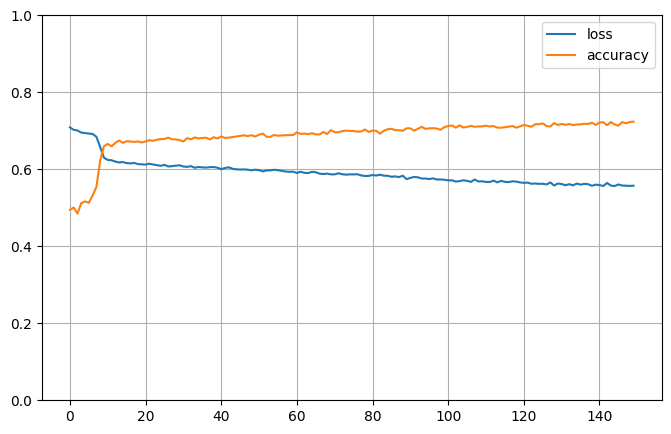

Validate
Round 2 Fold 5
Num samples in train and valid sets: 4796 1198
Train


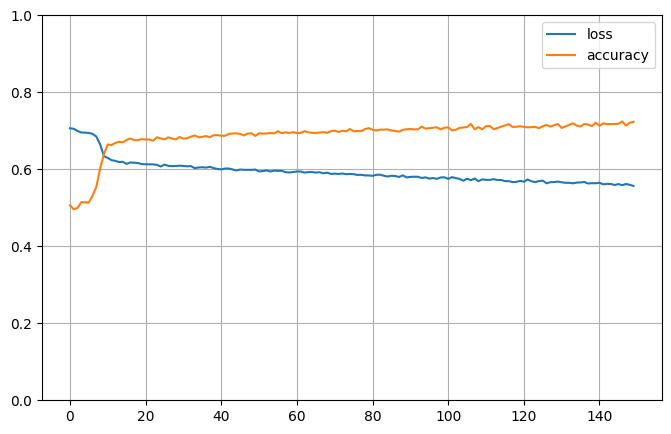

Validate

Cross validation results
  accuracy 70.65 mean,  1.435 stdev
[70.30859049207673, 71.55963302752293, 68.22351959966639, 71.3094245204337, 72.20367278797997, 69.97497914929107, 71.47623019182652, 67.97331109257715, 71.3094245204337, 72.12020033388981]
 precision 69.14 mean,  2.008 stdev
[70.41139240506328, 71.96428571428571, 66.89944134078212, 67.0028818443804, 69.78851963746223, 69.90595611285266, 72.07207207207207, 66.9985775248933, 66.57303370786516, 69.7428139183056]
    recall 75.14 mean,  4.337 stdev
[72.47557003257329, 68.6541737649063, 76.88603531300161, 80.17241379310344, 77.64705882352942, 72.63843648208469, 68.14310051107326, 75.60192616372392, 81.72413793103448, 77.47899159663866]
        F1 71.89 mean,  1.258 stdev
[71.42857142857142, 70.27027027027026, 71.54592979835698, 72.9984301412873, 73.50835322195704, 71.24600638977635, 70.05253940455341, 71.04072398190046, 73.37461300309597, 73.40764331210191]
       MCC 0.416 mean,  0.031 stdev
[0.4055754880939656, 0.43084

In [21]:
if True:
    print('Use our lncATLAS training set "all" (-inf <= CN-RCI <= +inf)')
    cyto_f = DATA_DIR+'ForRNAlight.mRNA_RCIgt-1.canonical.tsv'
    nuc_f  = DATA_DIR+'ForRNAlight.mRNA_RCIlt-1.canonical.tsv'
    print(cyto_f,'\n',nuc_f)
    dataset_cyto,dataset_nuc = load_dataframe(cyto_f,nuc_f)
    print('Rebalance (sample down the majority class) and repeat')
    dataset_cyto,dataset_nuc = rebalance(dataset_cyto,dataset_nuc)
    x_train, x_test, y_train, y_test = extract_features_and_split(dataset_cyto,dataset_nuc)
    stats = do_cv(x_train, y_train)
    print('\nCross validation results')
    stats.dump_all()

In [22]:
print(datetime.now())
print('Done')

2024-06-05 20:00:39.829254
Done
